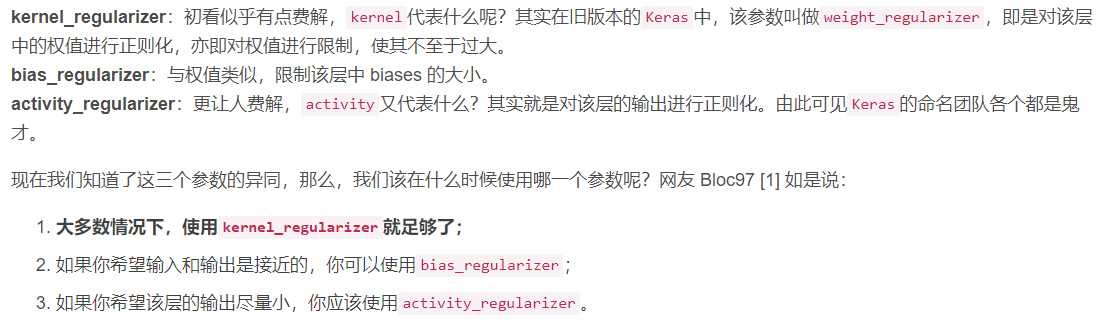

In [ ]:
#kernel_constraint 也要注意

model.add(layers.Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01), 
                activity_regularizer=regularizers.l1(0.01),
                kernel_constraint = constraints.MaxNorm(max_value=2, axis=0))) 
model.add(layers.Dense(10,
        kernel_regularizer=regularizers.l1_l2(0.01,0.01),activation = "sigmoid"))

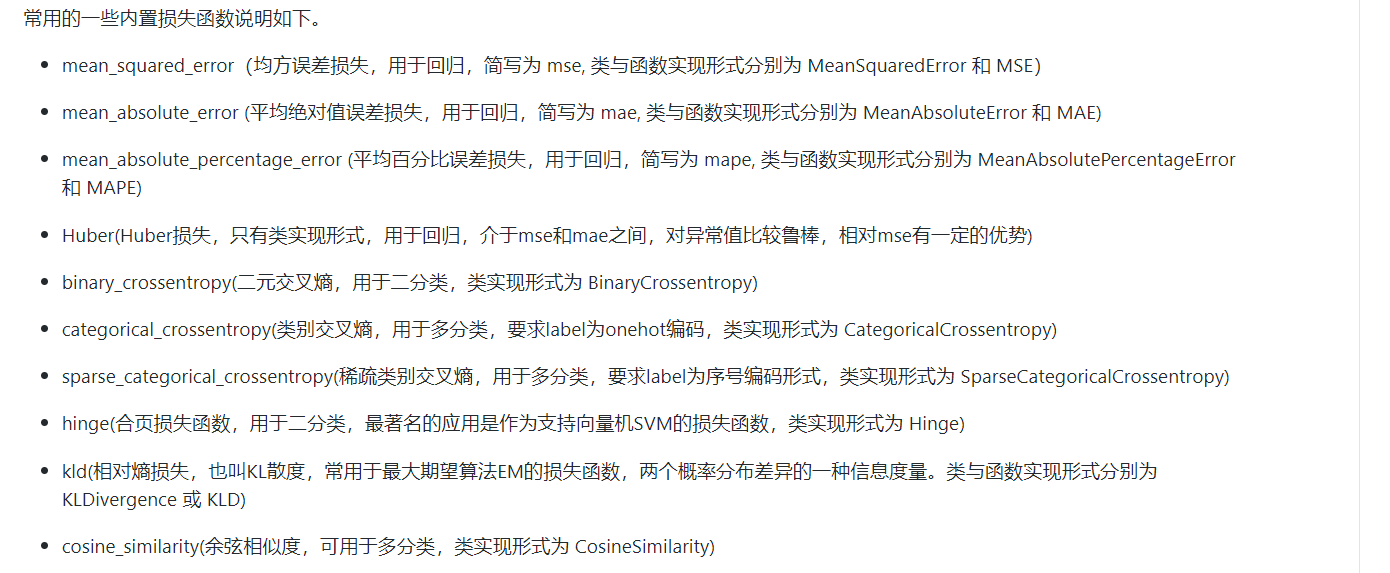

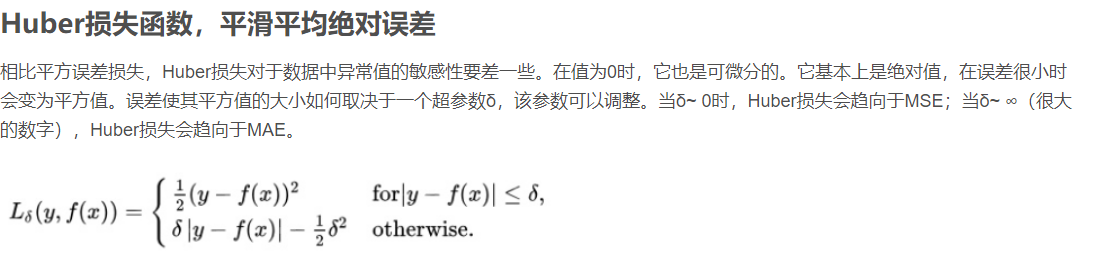

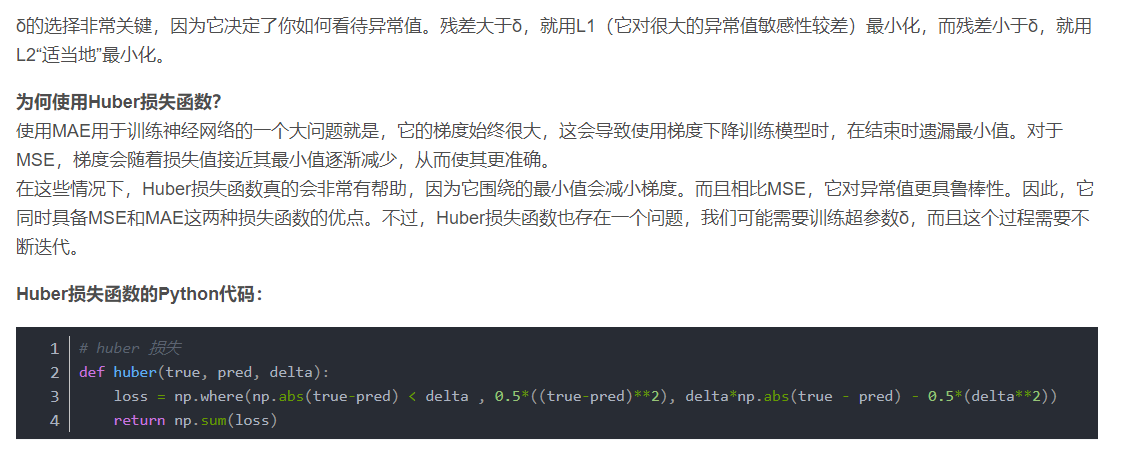

## Customized Loss Function

自定义损失函数接收两个张量y_true,y_pred作为输入参数，并输出一个标量作为损失函数值。

也可以对tf.keras.losses.Loss进行子类化，重写call方法实现损失的计算逻辑，从而得到损失函数的类的实现。

### focal loss template

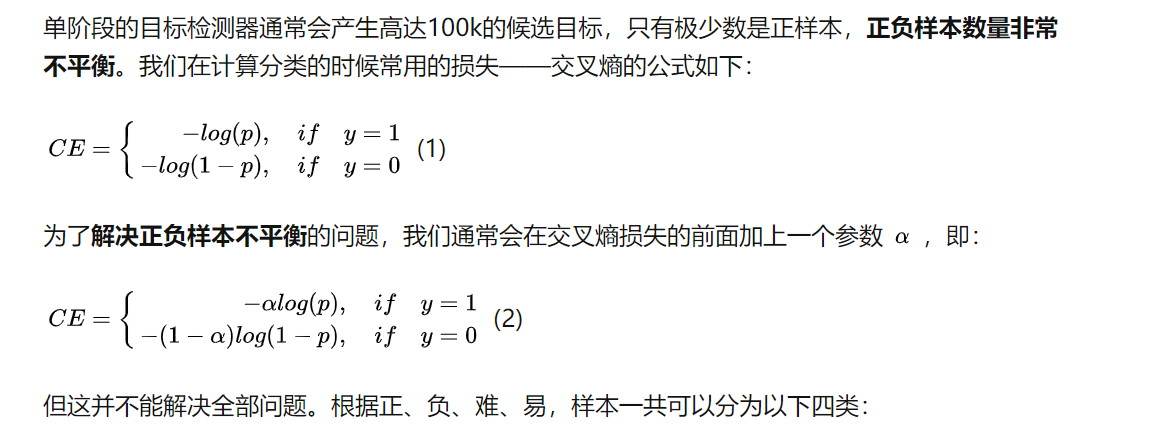

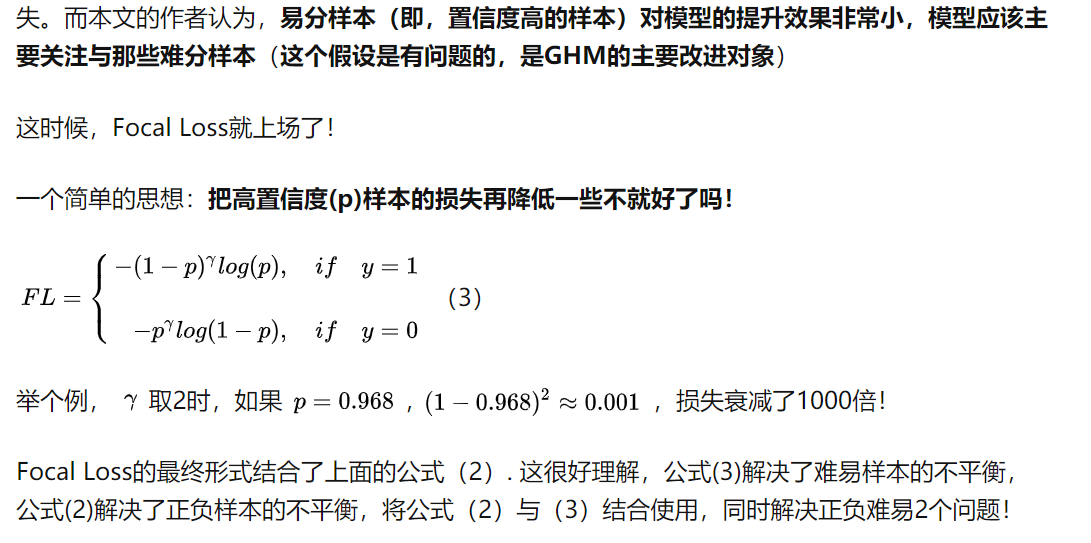

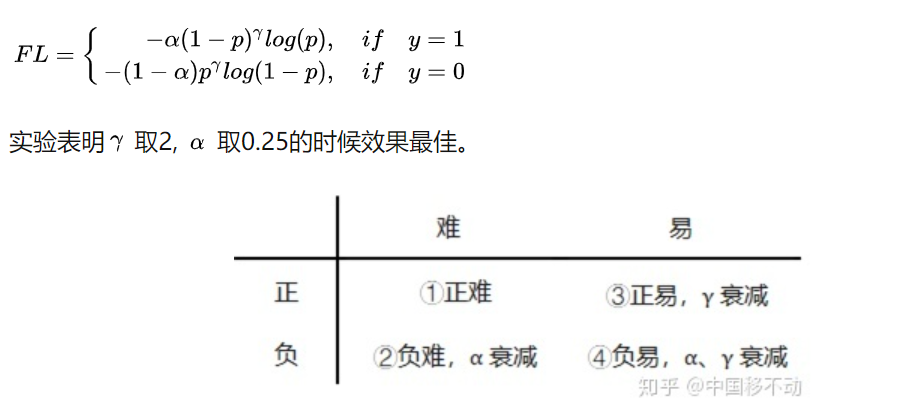

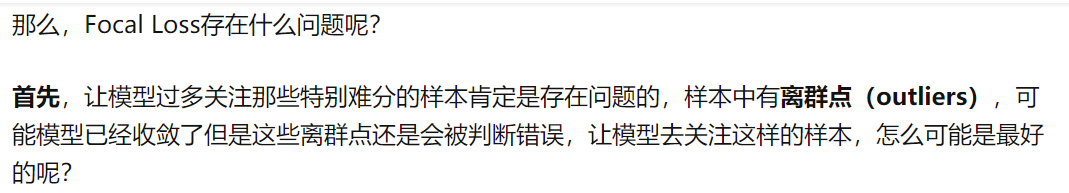

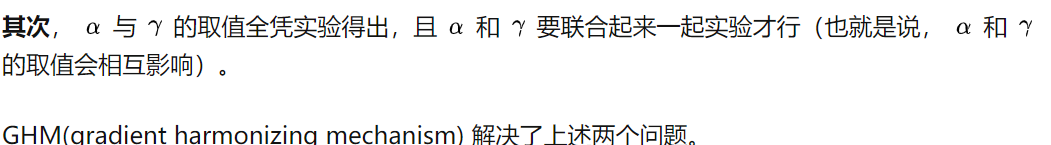

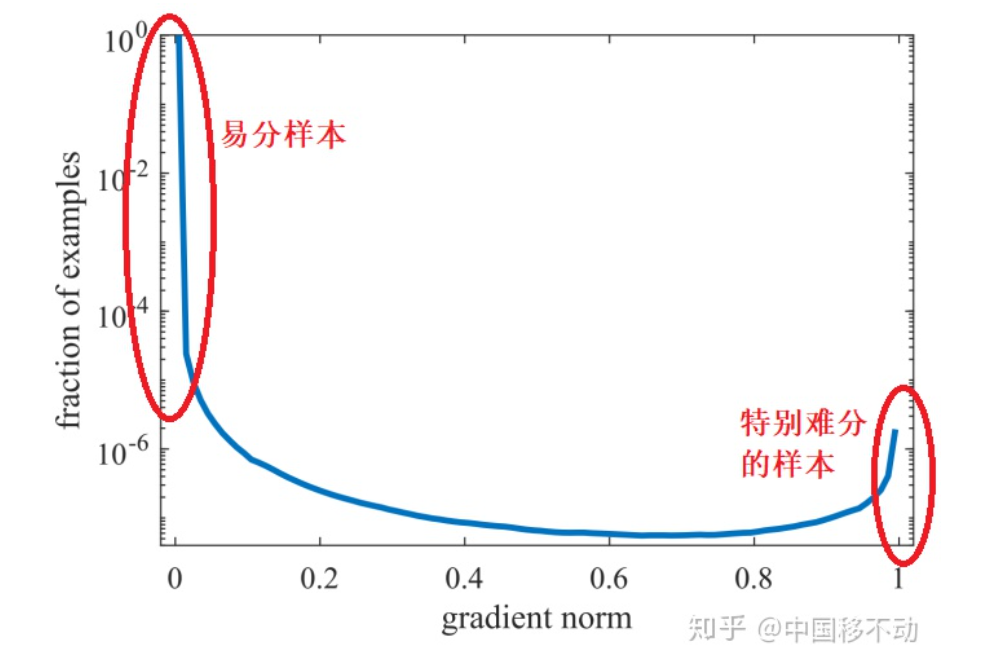

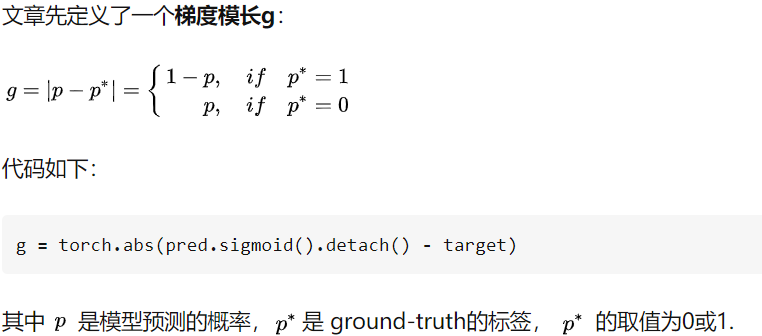

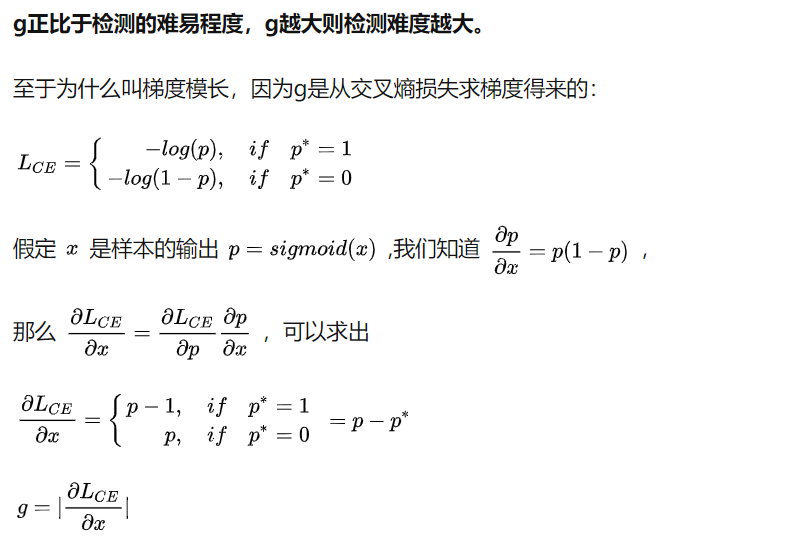

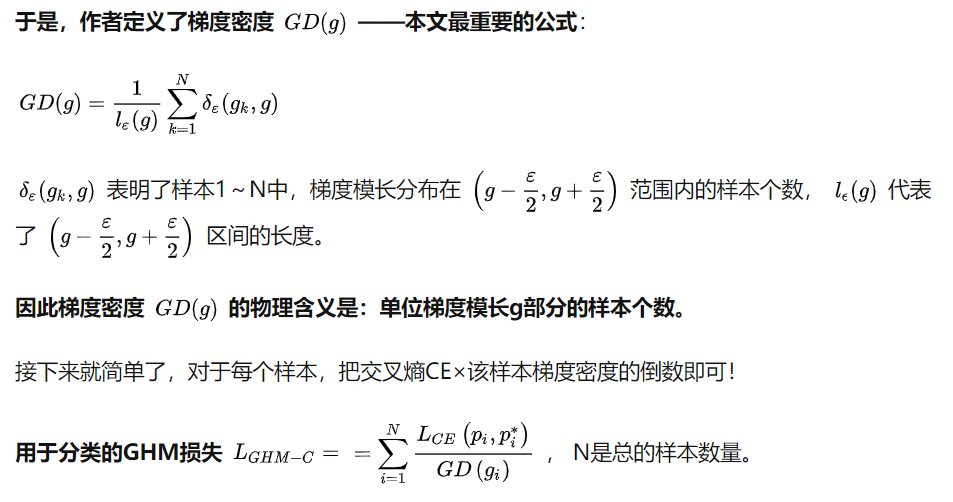

In [ ]:
# 计算梯度模长
g = torch.abs(pred.sigmoid().detach() - target)
# n 用来统计有效的区间数。
# 假如某个区间没有落入任何梯度模长，密度为0，需要额外考虑，不然取个倒数就无穷了。
n = 0  # n valid bins
# 通过循环计算落入10个bins的梯度模长数量
for i in range(self.bins):
    inds = (g >= edges[i]) & (g < edges[i + 1]) & valid
    num_in_bin = inds.sum().item()
    if num_in_bin > 0:
        # 重点，所谓的梯度密度就是1/num_in_bin
        weights[inds] = num_labels / num_in_bin 
        n += 1
if n > 0:
    weights = weights / n
# 把上面计算的weights填到binary_cross_entropy_with_logits里就行了
loss = torch.nn.functional.binary_cross_entropy_with_logits(
    pred, target, weights, reduction='sum') / num_labels

In [ ]:
def focal_loss(gamma=2., alpha=0.75):
    
    def focal_loss_fixed(y_true, y_pred):
        bce = tf.losses.binary_crossentropy(y_true, y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = tf.reduce_sum(alpha_factor * modulating_factor * bce,axis = -1 )
        return loss
    return focal_loss_fixed

In [ ]:
class FocalLoss(tf.keras.losses.Loss):
    
    def __init__(self,gamma=2.0,alpha=0.75,name = "focal_loss"):
        self.gamma = gamma
        self.alpha = alpha

    def call(self,y_true,y_pred):
        bce = tf.losses.binary_crossentropy(y_true, y_pred)
        p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
        alpha_factor = y_true * self.alpha + (1 - y_true) * (1 - self.alpha)
        modulating_factor = tf.pow(1.0 - p_t, self.gamma)
        loss = tf.reduce_sum(alpha_factor * modulating_factor * bce,axis = -1 )
        return loss

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers,models,losses,metrics

In [3]:
@tf.function
def ks(y_true,y_pred):
    y_true = tf.reshape(y_true,(-1,))
    y_pred = tf.reshape(y_pred,(-1,))
    length = tf.shape(y_true)[0]
    t = tf.math.top_k(y_pred,k = length,sorted = False)
    y_pred_sorted = tf.gather(y_pred,t.indices)
    y_true_sorted = tf.gather(y_true,t.indices)
    cum_positive_ratio = tf.truediv(
        tf.cumsum(y_true_sorted),tf.reduce_sum(y_true_sorted))
    cum_negative_ratio = tf.truediv(
        tf.cumsum(1 - y_true_sorted),tf.reduce_sum(1 - y_true_sorted))
    ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
    return ks_value

In [6]:

#类形式的自定义评估指标
class KS(metrics.Metric):
    
    def __init__(self, name = "ks", **kwargs):
        super(KS,self).__init__(name=name,**kwargs)
        self.true_positives = self.add_weight(
            name = "tp",shape = (101,), initializer = "zeros")
        self.false_positives = self.add_weight(
            name = "fp",shape = (101,), initializer = "zeros")
   
    @tf.function
    def update_state(self,y_true,y_pred):
        y_true = tf.cast(tf.reshape(y_true,(-1,)),tf.bool)
        y_pred = tf.cast(100*tf.reshape(y_pred,(-1,)),tf.int32)
        
        for i in tf.range(0,tf.shape(y_true)[0]):
            if y_true[i]:
                self.true_positives[y_pred[i]].assign(
                    self.true_positives[y_pred[i]]+1.0)
            else:
                self.false_positives[y_pred[i]].assign(
                    self.false_positives[y_pred[i]]+1.0)
        return (self.true_positives,self.false_positives)
    
    @tf.function
    def result(self):
        cum_positive_ratio = tf.truediv(
            tf.cumsum(self.true_positives),tf.reduce_sum(self.true_positives))
        cum_negative_ratio = tf.truediv(
            tf.cumsum(self.false_positives),tf.reduce_sum(self.false_positives))
        ks_value = tf.reduce_max(tf.abs(cum_positive_ratio - cum_negative_ratio)) 
        return ks_value

# Optimizer

In [23]:
# 求f(x) = a*x**2 + b*x + c的最小值

# 使用optimizer.apply_gradients

x = tf.Variable(0.0,name = "x",dtype = tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

@tf.function
def minimizef():
    a = tf.constant(1.0)
    b = tf.constant(-2.0)
    c = tf.constant(1.0)
    
    
    # 不用while(1):
    while tf.constant(True):
        # 求tap
        with tf.GradientTape() as tape:
            y = a*tf.pow(x,2) + b*x + c
        dy_dx = tape.gradient(y,x)
        optimizer.apply_gradients(grads_and_vars=[(dy_dx,x)])
        
        #迭代终止条件
        if tf.abs(dy_dx)<tf.constant(0.00001):
            break
        
        # 不用%
        if tf.math.mod(optimizer.iterations,100)==0:
            printbar()
            tf.print("step = ",optimizer.iterations)
            tf.print("x = ", x)
            tf.print("")
                
    y = a*tf.pow(x,2) + b*x + c
    return y

tf.print("y =",minimizef())
tf.print("x =",x)

<tf.Tensor: shape=(14,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1])>

In [26]:
# 求f(x) = a*x**2 + b*x + c的最小值

# 使用optimizer.minimize

x = tf.Variable(0.0,name = "x",dtype = tf.float32)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)   

def f():   
    a = tf.constant(1.0)
    b = tf.constant(-2.0)
    c = tf.constant(1.0)
    y = a*tf.pow(x,2)+b*x+c
    return(y)

@tf.function
def train(epoch = 1000):  
    for _ in tf.range(epoch):  
        optimizer.minimize(f,[x])
    tf.print("epoch = ",optimizer.iterations)
    return(f())

train(1000)
tf.print("y = ",f())
tf.print("x = ",x)

In [25]:
# 求f(x) = a*x**2 + b*x + c的最小值
# 使用model.fit

tf.keras.backend.clear_session()

class FakeModel(tf.keras.models.Model):
    def __init__(self,a,b,c):
        super(FakeModel,self).__init__()
        self.a = a
        self.b = b
        self.c = c
    
    def build(self):
        self.x = tf.Variable(0.0,name = "x")
        self.built = True
    
    def call(self,features):
        loss  = self.a*(self.x)**2+self.b*(self.x)+self.c
        return(tf.ones_like(features)*loss)
    
def myloss(y_true,y_pred):
    return tf.reduce_mean(y_pred)

model = FakeModel(tf.constant(1.0),tf.constant(-2.0),tf.constant(1.0))

model.build()
model.summary()

model.compile(optimizer = 
              tf.keras.optimizers.SGD(learning_rate=0.01),loss = myloss)
history = model.fit(tf.zeros((100,2)),
                    tf.ones(100),batch_size = 1,epochs = 10)  #迭代1000次

8

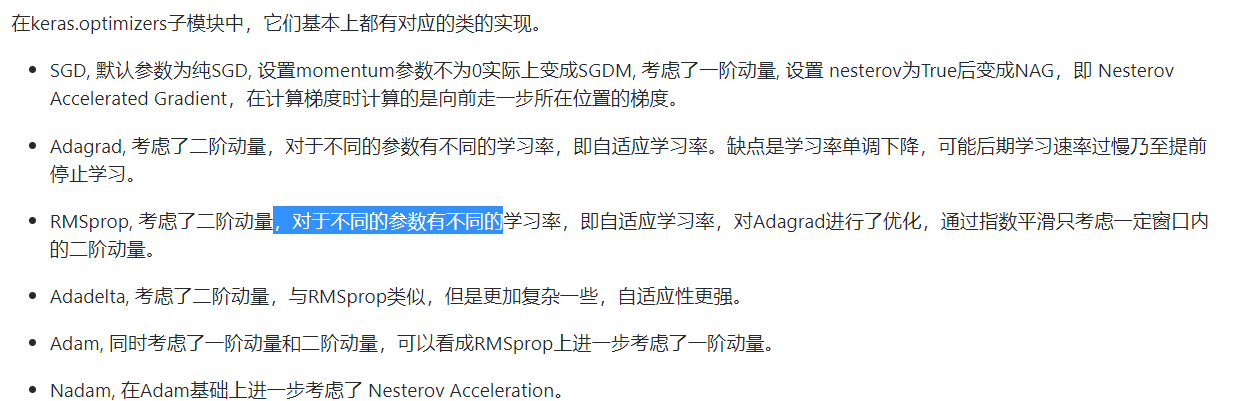

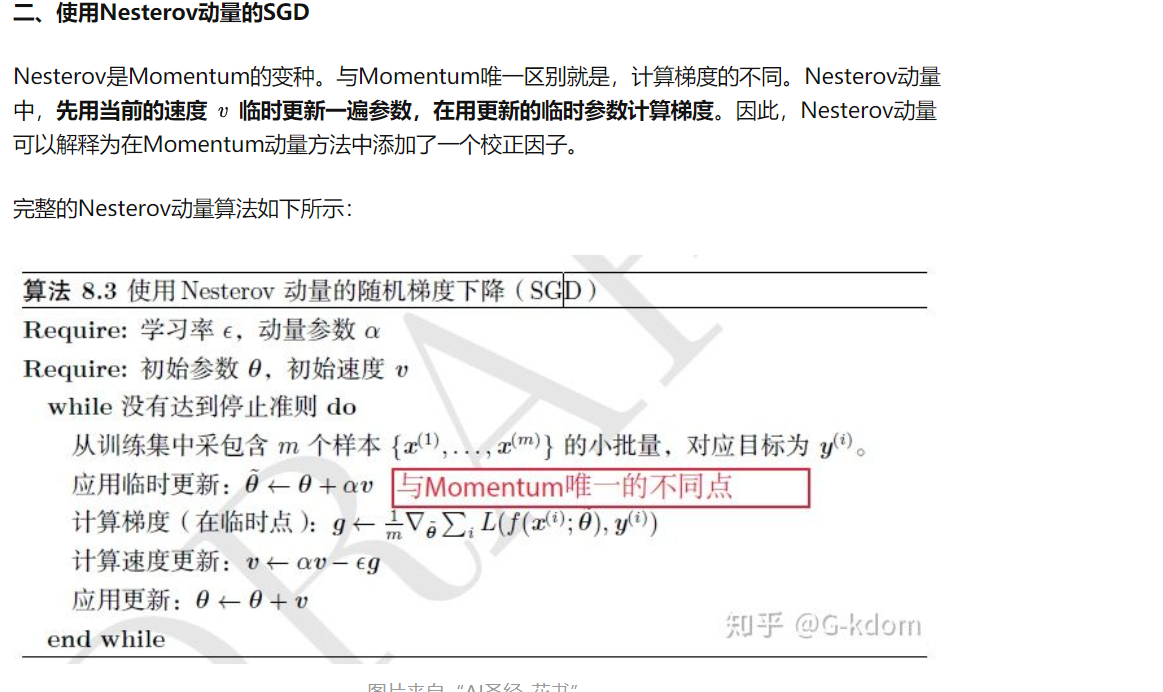